In [39]:
import os
from src.config.config_defaults import ConfigDefault
from pathlib import Path
import pyrootutils
import IPython
from src.utils.utils_audio import plot_spectrograms
import warnings
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

path_workdir: Path = Path(pyrootutils.find_root(search_from=os.curdir, indicator=".project-root"))
os.chdir(Path(path_workdir))

config = ConfigDefault()

def play_audio(audio, rate):
    IPython.display.display(IPython.display.Audio(data=audio, rate=rate))
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import librosa
from src.enums.enums import SupportedAugmentations
from src.config.config_defaults import (
    get_default_config,
)
from src.features.augmentations import get_augmentations

from src.utils.utils_dataset import (
    get_example_val_sample,
)
from src.features.audio_to_spectrogram import MelSpectrogram
from src.utils.utils_audio import spec_width_to_num_samples

warnings.filterwarnings("ignore")


Mel to audio...
Original audio from spectrogram


(128, 384)


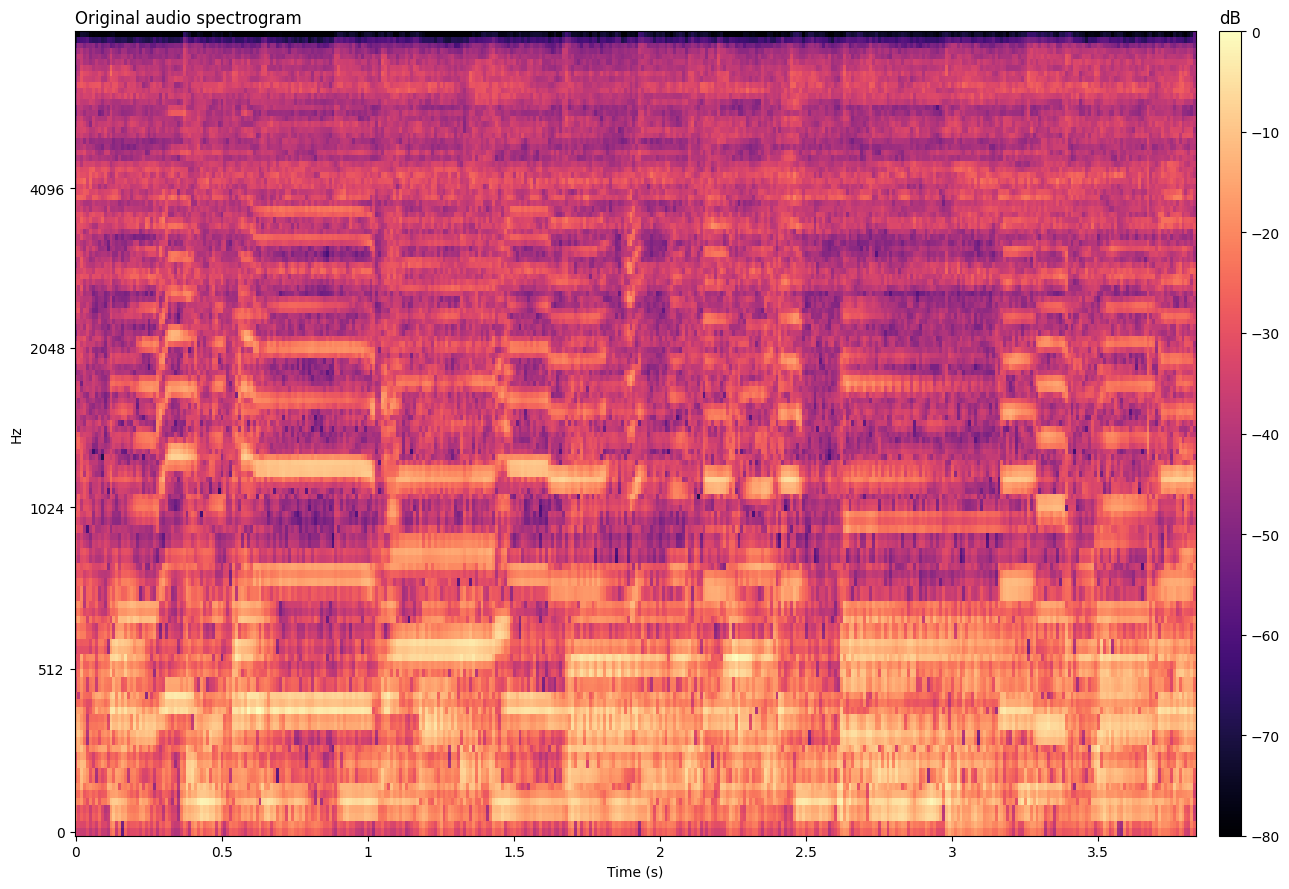

In [41]:


audio = get_example_val_sample(config.sampling_rate)
config.image_size=(384, 384)
limit = spec_width_to_num_samples(config.image_size[-1], config.hop_length)

audio = audio[: limit]
config = get_default_config()
spec_original = librosa.feature.melspectrogram(
    y=audio,
    sr=config.sampling_rate,
    n_fft=config.n_fft,
    hop_length=config.hop_length,
    n_mels=config.n_mels,
)
print("Mel to audio...")
audio_from_spec = librosa.feature.inverse.mel_to_audio(
    spec_original,
    sr=config.sampling_rate,
    n_fft=config.n_fft,
    hop_length=config.hop_length,
)

print("Original audio from spectrogram")
play_audio(audio_from_spec, config.sampling_rate)
print(spec_original.shape)
plot_spectrograms(spec_original, sampling_rate=config.sampling_rate, hop_length=config.hop_length,n_fft=config.n_fft, n_mels=config.n_mels, titles=["Original audio spectrogram"])

Mel to audio...
Augmented sound:


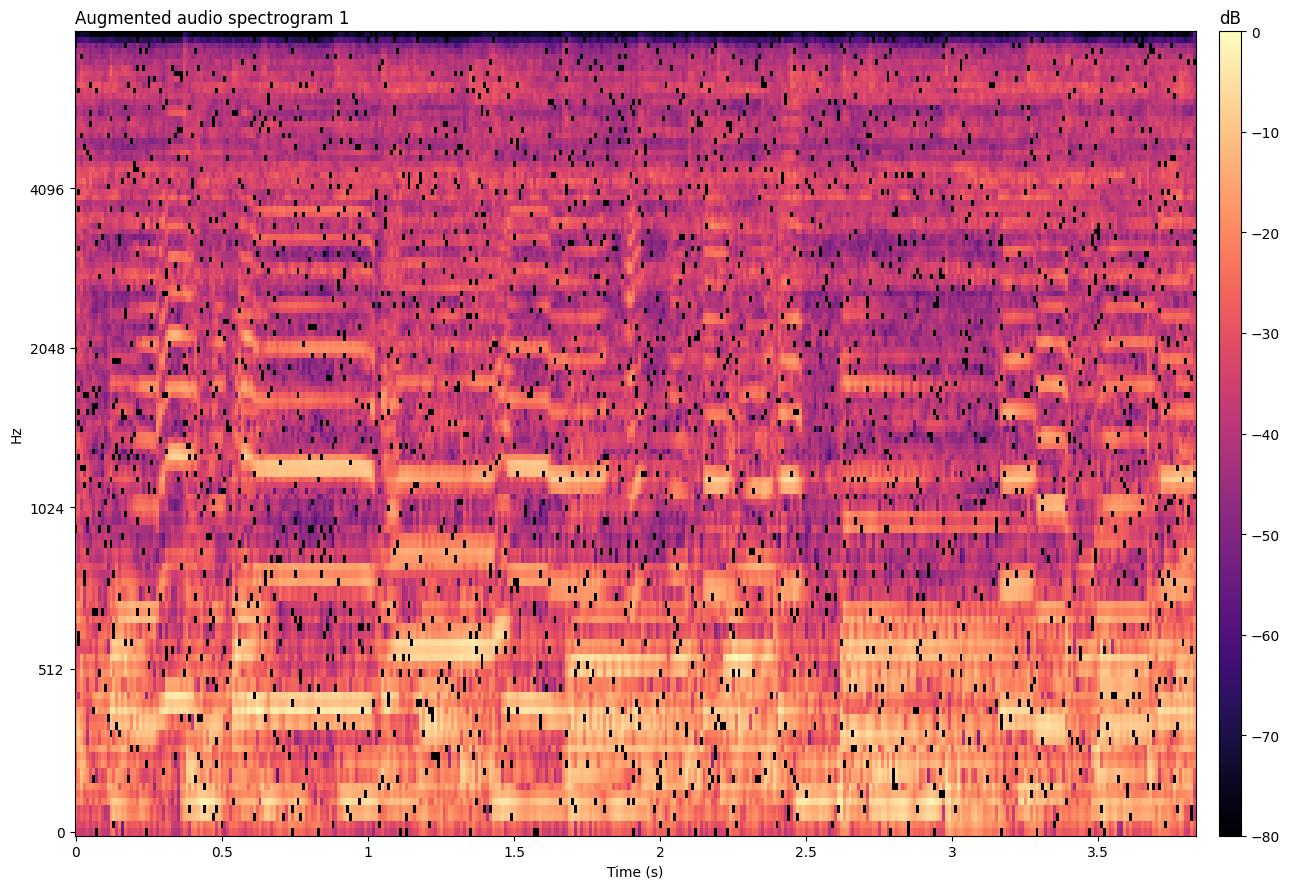

Mel to audio...
Augmented sound:


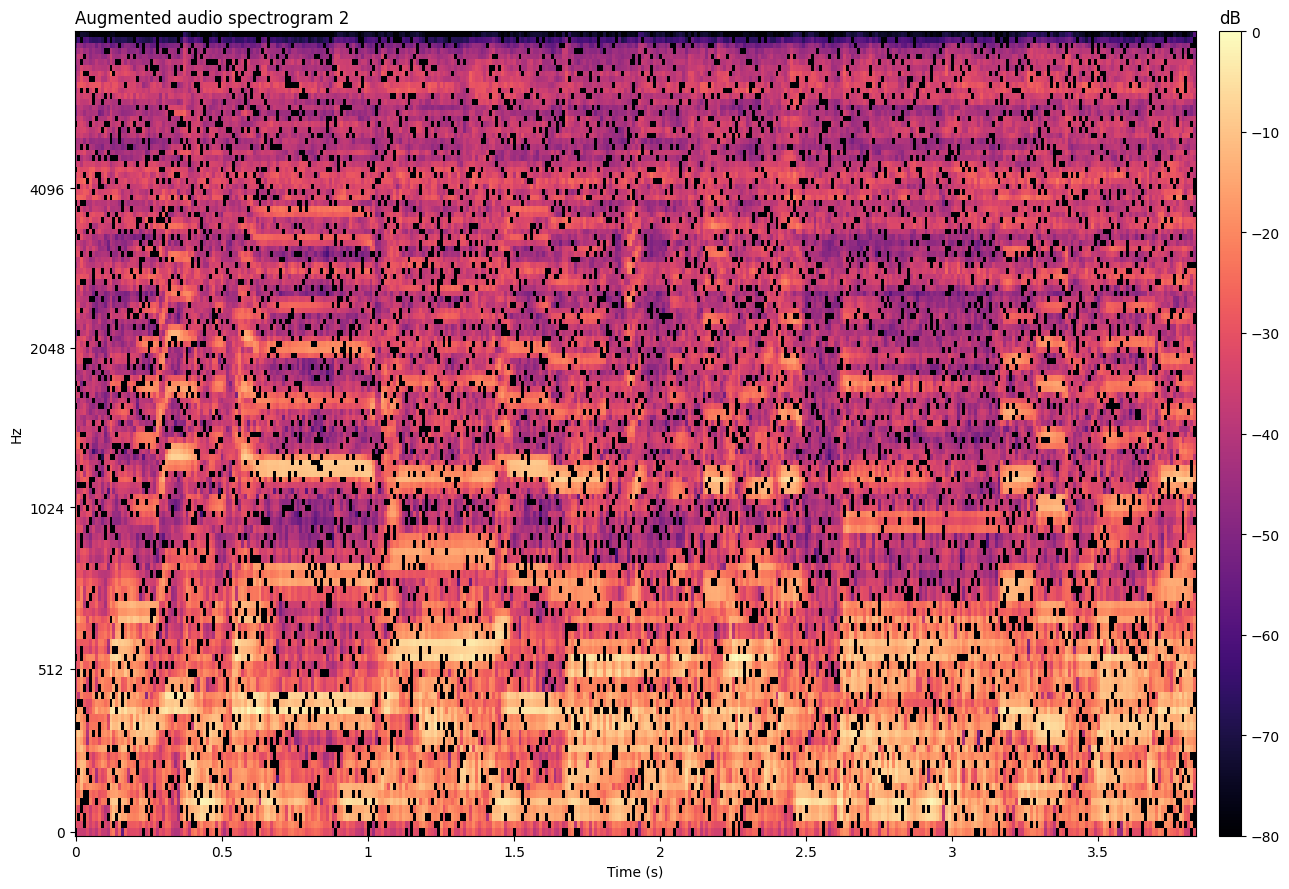

Mel to audio...
Augmented sound:


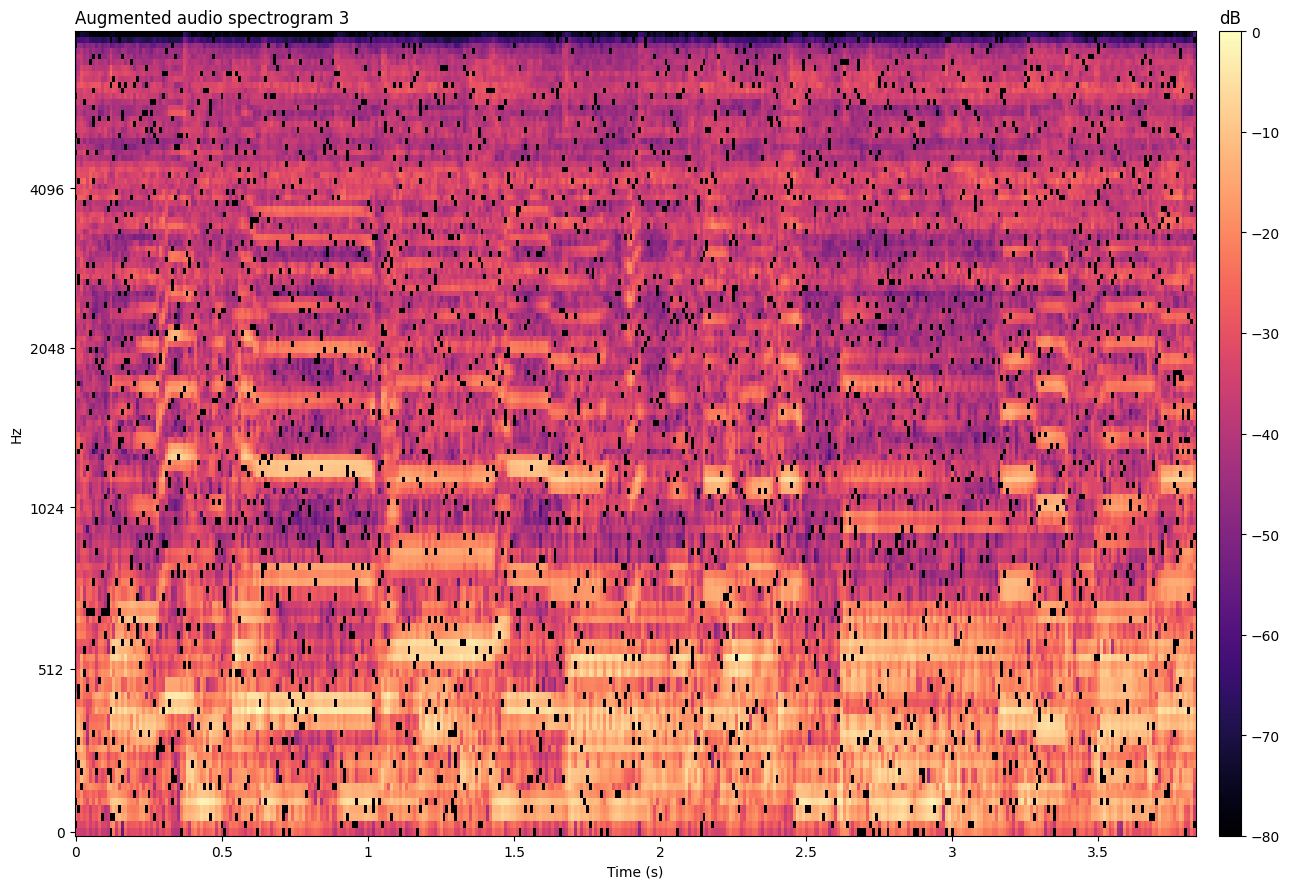

In [42]:



warnings.filterwarnings("ignore")
config = get_default_config()
config.augmentations = [
    #SupportedAugmentations.BACKGROUND_NOISE,
    #SupportedAugmentations.TIME_STRETCH,
    #SupportedAugmentations.TIME_SHIFT,
    #SupportedAugmentations.PITCH,
    #SupportedAugmentations.COLOR_NOISE,
    #SupportedAugmentations.TIMEINV,
    #SupportedAugmentations.TIME_MASK,
    #SupportedAugmentations.NORM_AFTER_TIME_AUGS,
    #SupportedAugmentations.FREQ_MASK,
    #SupportedAugmentations.RANDOM_ERASE,
    SupportedAugmentations.RANDOM_PIXELS,
]
(
    train_spectrogram_augmentation,
    train_waveform_augmentation,
    _,
    _,
) = get_augmentations(config)

config.image_size=(384, 384)

# train_spectrogram_augmentation = None
# train_waveform_augmentation = None

transform = MelSpectrogram(
    sampling_rate=config.sampling_rate,
    hop_length=config.hop_length,
    n_fft=config.n_fft,
    n_mels=config.n_mels,
    image_size=config.image_size,
    spectrogram_augmentation=train_spectrogram_augmentation,
    waveform_augmentation=train_waveform_augmentation,
    max_num_width_samples=config.max_num_width_samples,
    normalize_audio=True,
    normalize_image=False,
    use_rgb=False,
)

for i in range(3):
    spectrogram_trans = transform(audio)
    # Undoes the scaling but not augmentations
    spectrogram_trans = transform.undo(spectrogram_trans)[0].numpy()

    print("Mel to audio...")
    audio_from_trans_spec = librosa.feature.inverse.mel_to_audio(
        spectrogram_trans,
        sr=config.sampling_rate,
        n_fft=config.n_fft,
        hop_length=config.hop_length,
    )
    print("Augmented sound:")
    play_audio(audio_from_trans_spec, config.sampling_rate)
    
    plot_spectrograms(spectrogram_trans, sampling_rate=config.sampling_rate, hop_length=config.hop_length,n_fft=config.n_fft, n_mels=config.n_mels, titles=[f"Augmented audio spectrogram {i+1}"])